## Import Libraries 

In [1]:
import io
import os
from rdkit import Chem
from collections import defaultdict
import pandas as pd
from rdkit.Chem import Draw, AllChem
from PIL import Image as PILImage, ImageDraw, ImageFont
from IPython.display import display, Image

## Import Molecules 

In [2]:
def load_molecules(file_name):
  file_extension = os.path.splitext(file_name)[1].lower()
  molecules = []
  
  try:
      if file_extension == '.sdf':
          suppl = Chem.SDMolSupplier(file_name)
          molecules = [mol for mol in suppl if mol is not None]
      elif file_extension == '.smi':
          with open(file_name, 'r') as f:
              for line in f:
                  smiles = line.strip()
                  mol = Chem.MolFromSmiles(smiles)
                  if mol:
                      molecules.append(mol)
      elif file_extension == '.csv':
          df = pd.read_csv(file_name)
          if 'smiles' in df.columns and 'molecule_id' in df.columns:
              for idx, row in df.iterrows():
                  mol = Chem.MolFromSmiles(row['smiles'])
                  if mol:
                      # Set the molecule name to the molecule_id
                      mol.SetProp('_Name', str(row['molecule_id']))
                      molecules.append(mol)
          else:
              print("CSV file must contain 'smiles' and 'molecule_id' columns.")
      else:
          print("Unsupported file format. Please use .sdf, .smi, or .csv.")
  except Exception as e:
      print(f"Error loading file: {e}")
  
  return molecules

In [4]:
# Define the file name you want to load
file_name = 'drugbank_approved_structures.sdf'  # Replace with your actual file name, e.g., 'molecules.sdf', 'molecules.smi', or 'molecules.csv'

# Load molecules using the defined file name
molecules = load_molecules(file_name)

# Check if molecules were loaded successfully
if not molecules:
  print("No molecules loaded. Please check the file path and format.")
else:
  print(f"Loaded {len(molecules)} molecules from {file_name}.")

[16:36:06] Warning: ambiguous stereochemistry - linear bond arrangement - at atom 18 ignored
[16:36:06] Warning: ambiguous stereochemistry - zero final chiral volume - at atom 11 ignored
[16:36:06] Warning: ambiguous stereochemistry - opposing bonds have opposite wedging - at atom 20 ignored.
[16:36:06] Warning: ambiguous stereochemistry - opposing bonds have opposite wedging - at atom 20 ignored.
[16:36:06] Explicit valence for atom # 28 N, 4, is greater than permitted
[16:36:06] ERROR: Could not sanitize molecule ending on line 322012
[16:36:06] ERROR: Explicit valence for atom # 28 N, 4, is greater than permitted


Loaded 2508 molecules from drugbank_approved_structures.sdf.


[16:36:07] WARNING: not removing hydrogen atom without neighbors


## Define SMARTS patterns

In [6]:
# Read the CSV file into a DataFrame
substruct_df = pd.read_csv('substructures-ring.csv')

# Convert the DataFrame to a dictionary
substructure_smarts = dict(zip(substruct_df['Name of Substructure'], substruct_df['SMILES']))

# Print the expanded list
for name, smarts in substructure_smarts.items():
  print(f"{name}: {smarts}")

pyridine: n1ccccc1
pyrimidine: c1ncnc[nH]1
purine: c1[nH]c2c(n1)c(nc[nH]2)N
indole: c1ccc2c(c1)[nH]c1ccccc21
quinoline: c1ccc2c(c1)ccn2
isoquinoline: c1ccc2c(c1)ccn2
thiazole: c1scnc1
oxazole: c1ocnc1
imidazole: c1[nH]cnc1
furan: o1cccc1
thiophene: s1cccc1
triazole: c1nn[nH]n1
tetrazole: c1nnnn1
piperidine: N1CCCCC1
piperazine: N1CCNCC1
morpholine: O1CCNCC1
benzofuran: c1ccc2c(c1)oc3c2cccc3
benzothiophene: c1ccc2c(c1)sc3c2cccc3
imidazoline: C1CNCCN1
oxazoline: C1CONCC1
thiazoline: C1CSCCN1
pyrazole: c1ccn[nH]1
pyrrole: [nH]1cccc1
selenophene: c1cc[se]c1
tellurophene: c1cc[te]c1
phthalazine: c1ccc2c(c1)c(=O)n[nH]n2
pteridine: c1cc2c(nc[nH]1)ncn2
xanthine: O=C2Nc1nc[nH]c1C(=O)N2C
caffeine: CN1C=NC2=C1C(=O)N(C(=O)N2C)C
sterol: C1CCC2C(C1)CC3C4CCC5C6(C)CCC(C6CCC5(C4(CCC3C2)C)C)(C)C
triazolopyrimidine: c1nnn(c2ncnc12)N
tetrahydrofuran: O1CCCC1
tetrahydropyran: O1CCCCC1
oxazolidinone: C1COC(=O)N1
thiazolidinone: C1CSC(=O)N1
oxadiazole: c1nocn1
thiadiazole: c1nscn1
pyrazine: c1cnccn1
pyridazi

In [7]:
# Function to find invalid SMARTS patterns
def find_invalid_smarts(smarts_patterns):
  invalid_smarts = []
  for name, smarts in smarts_patterns.items():
      substructure = Chem.MolFromSmarts(smarts)
      if substructure is None:
          invalid_smarts.append((name, smarts))
  return invalid_smarts

# Find and print invalid SMARTS patterns
invalid_smarts_patterns = find_invalid_smarts(substructure_smarts)
if invalid_smarts_patterns:
  print("Invalid SMARTS patterns found:")
  for name, smarts in invalid_smarts_patterns:
      print(f"{name}: {smarts}")
else:
  print("No invalid SMARTS patterns found.")

# Function to find common substructures and the names of molecules containing them
def find_common_substructures_with_molecule_names(molecules, smarts_patterns):
  substruct_info = defaultdict(lambda: {'count': 0, 'molecules': []})
  
  for mol_idx, mol in enumerate(molecules):
      mol_name = mol.GetProp('_Name') if mol.HasProp('_Name') else f'Molecule_{mol_idx}'
      for name, smarts in smarts_patterns.items():
          substructure = Chem.MolFromSmarts(smarts)
          if substructure and mol.HasSubstructMatch(substructure):
              substruct_info[name]['count'] += 1
              substruct_info[name]['molecules'].append(mol_name)
  
  return substruct_info

No invalid SMARTS patterns found.


## Function to find common substructures

In [8]:
# Function to find common substructures
def find_common_substructures(molecules, smarts_patterns):
    substruct_counts = defaultdict(int)
    
    for mol in molecules:
        for name, smarts in smarts_patterns.items():
            substructure = Chem.MolFromSmarts(smarts)
            if mol.HasSubstructMatch(substructure):
                substruct_counts[name] += 1
    
    return substruct_counts

## Substructure Count and Molecules names

In [9]:
# Modified function to find common substructures and the names of molecules containing them
def find_common_substructures_with_molecule_names(molecules, smarts_patterns):
    substruct_info = defaultdict(lambda: {'count': 0, 'molecules': []})
    
    for mol_idx, mol in enumerate(molecules):
        mol_name = mol.GetProp('_Name') if mol.HasProp('_Name') else f'Molecule_{mol_idx}'
        for name, smarts in smarts_patterns.items():
            substructure = Chem.MolFromSmarts(smarts)
            if mol.HasSubstructMatch(substructure):
                substruct_info[name]['count'] += 1
                substruct_info[name]['molecules'].append(mol_name)
    
    return substruct_info

# Execute the modified function
common_substructs_info = find_common_substructures_with_molecule_names(molecules, substructure_smarts)

In [10]:
# Convert results to Pandas DataFrame
data = []
for substruct, info in common_substructs_info.items():
    data.append([substruct, info['count'], ", ".join(info['molecules'])])

substruct_df_extended = pd.DataFrame(data, columns=['Substructure', 'Count', 'Molecule Names'])

# Sort the DataFrame by 'Count' in descending order
substruct_df_sorted_extended = substruct_df_extended.sort_values(by='Count', ascending=False)

# Print the sorted DataFrame
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
substruct_df_sorted_extended

,Substructure,Count,Molecule Names
8,cyclohexane,304,"DB00136, DB00146, DB00153, DB00169, DB00180, D..."
4,pyridine,246,"DB00050, DB00106, DB00114, DB00165, DB00184, D..."
7,cyclopentane,223,"DB00136, DB00146, DB00153, DB00169, DB00178, D..."
14,piperidine,221,"DB00185, DB00206, DB00209, DB00218, DB00220, D..."
19,imidazoline,116,"DB00203, DB00224, DB00236, DB00243, DB00246, D..."
18,piperazine,116,"DB00203, DB00224, DB00236, DB00243, DB00246, D..."
17,tetrahydropyran,109,"DB00199, DB00207, DB00227, DB00273, DB00284, D..."
0,quinoline,92,"DB00007, DB00014, DB00027, DB00080, DB00104, D..."
1,isoquinoline,92,"DB00007, DB00014, DB00027, DB00080, DB00104, D..."
3,pyrrole,89,"DB00007, DB00014, DB00027, DB00080, DB00104, D..."


## Vizulize Substructure and Molecules

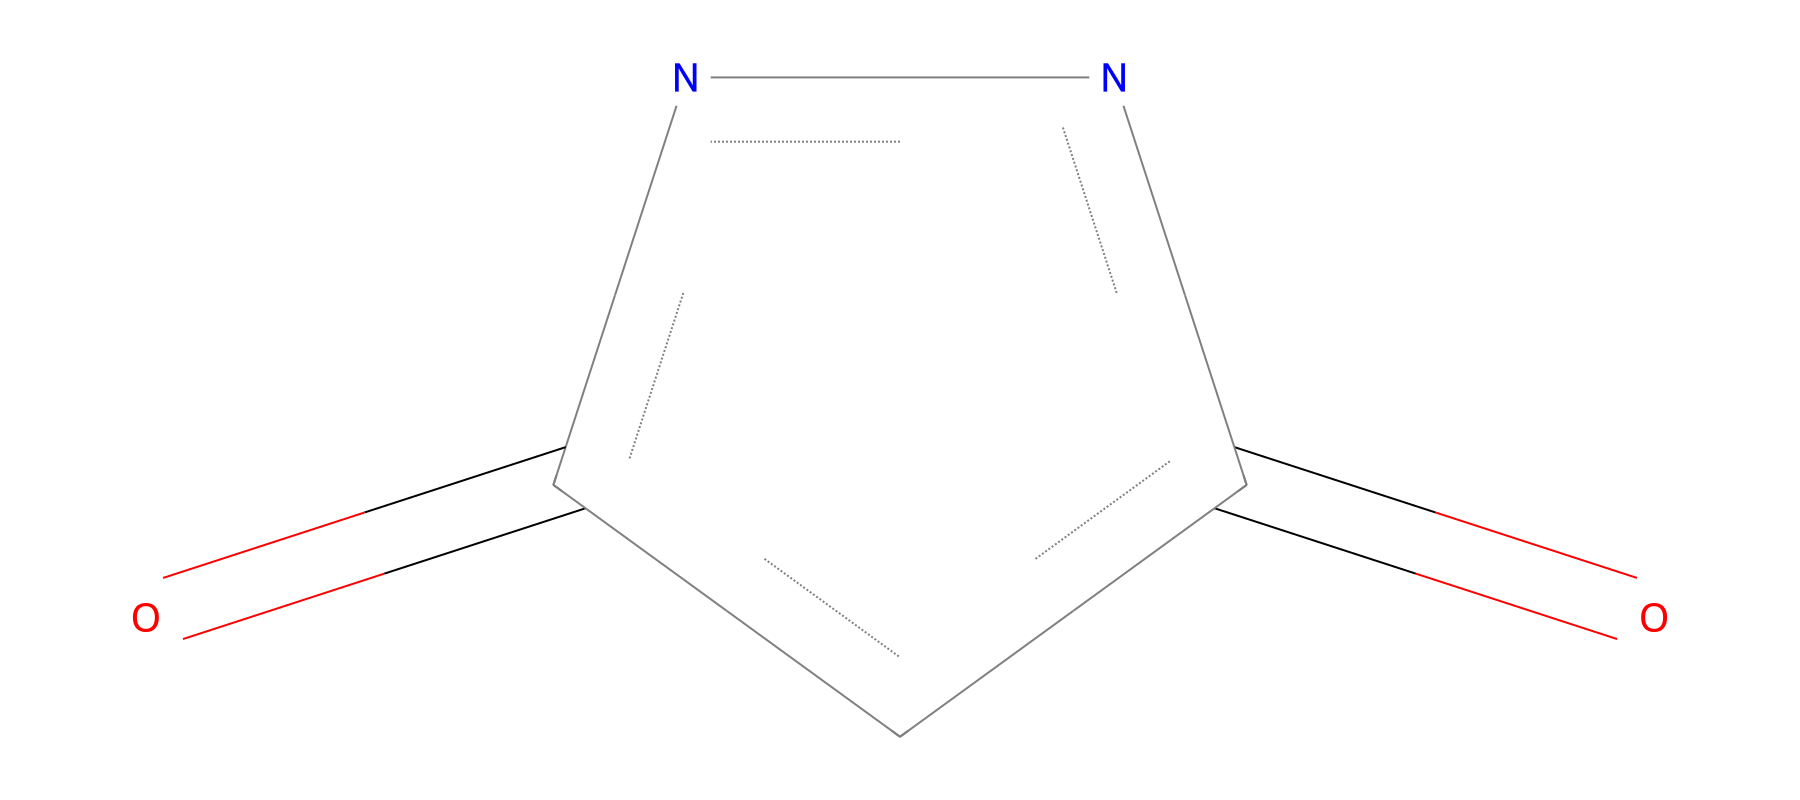

Image saved as pyrazolone.png


In [75]:
# Prompt the user to enter the name of the substructure
user_input = input("Enter the name of the substructure (e.g., acridine): ")

# Ensure the substructure name is defined in the dictionary
if user_input in substructure_smarts:
    substructure_smarts_pattern = substructure_smarts[user_input]

    # Find molecules containing the substructure
    substructure = Chem.MolFromSmarts(substructure_smarts_pattern)
    molecules_with_substructure = [mol for mol in molecules if mol.HasSubstructMatch(substructure)]

    # Draw the substructure with a larger size
    substructure_mol = Chem.MolFromSmarts(substructure_smarts_pattern)
    img_substructure = Draw.MolToImage(substructure_mol, size=(1800, 800))

    # Display the substructure image
    display(img_substructure)

    # Convert the RDKit image to a PIL image for saving
    img_byte_arr = io.BytesIO()
    img_substructure.save(img_byte_arr, format='PNG')
    img_byte_arr = img_byte_arr.getvalue()
    pil_img_substructure = PILImage.open(io.BytesIO(img_byte_arr))

    # Specify the filename and dpi
    filename = f"{user_input}.png"
    dpi = 300  # Dots per inch for the image file

    # Save the image
    pil_img_substructure.save(filename, 'PNG', dpi=(dpi, dpi))

    print(f"Image saved as {filename}")

    # Get the names of the molecules, assuming they have a '_Name' property
    molecule_names = [mol.GetProp('_Name') if mol.HasProp('_Name') else "Unnamed" for mol in molecules_with_substructure]
else:
    print("Substructure not found in the dictionary.")

## Molecules highlighted with the substructure

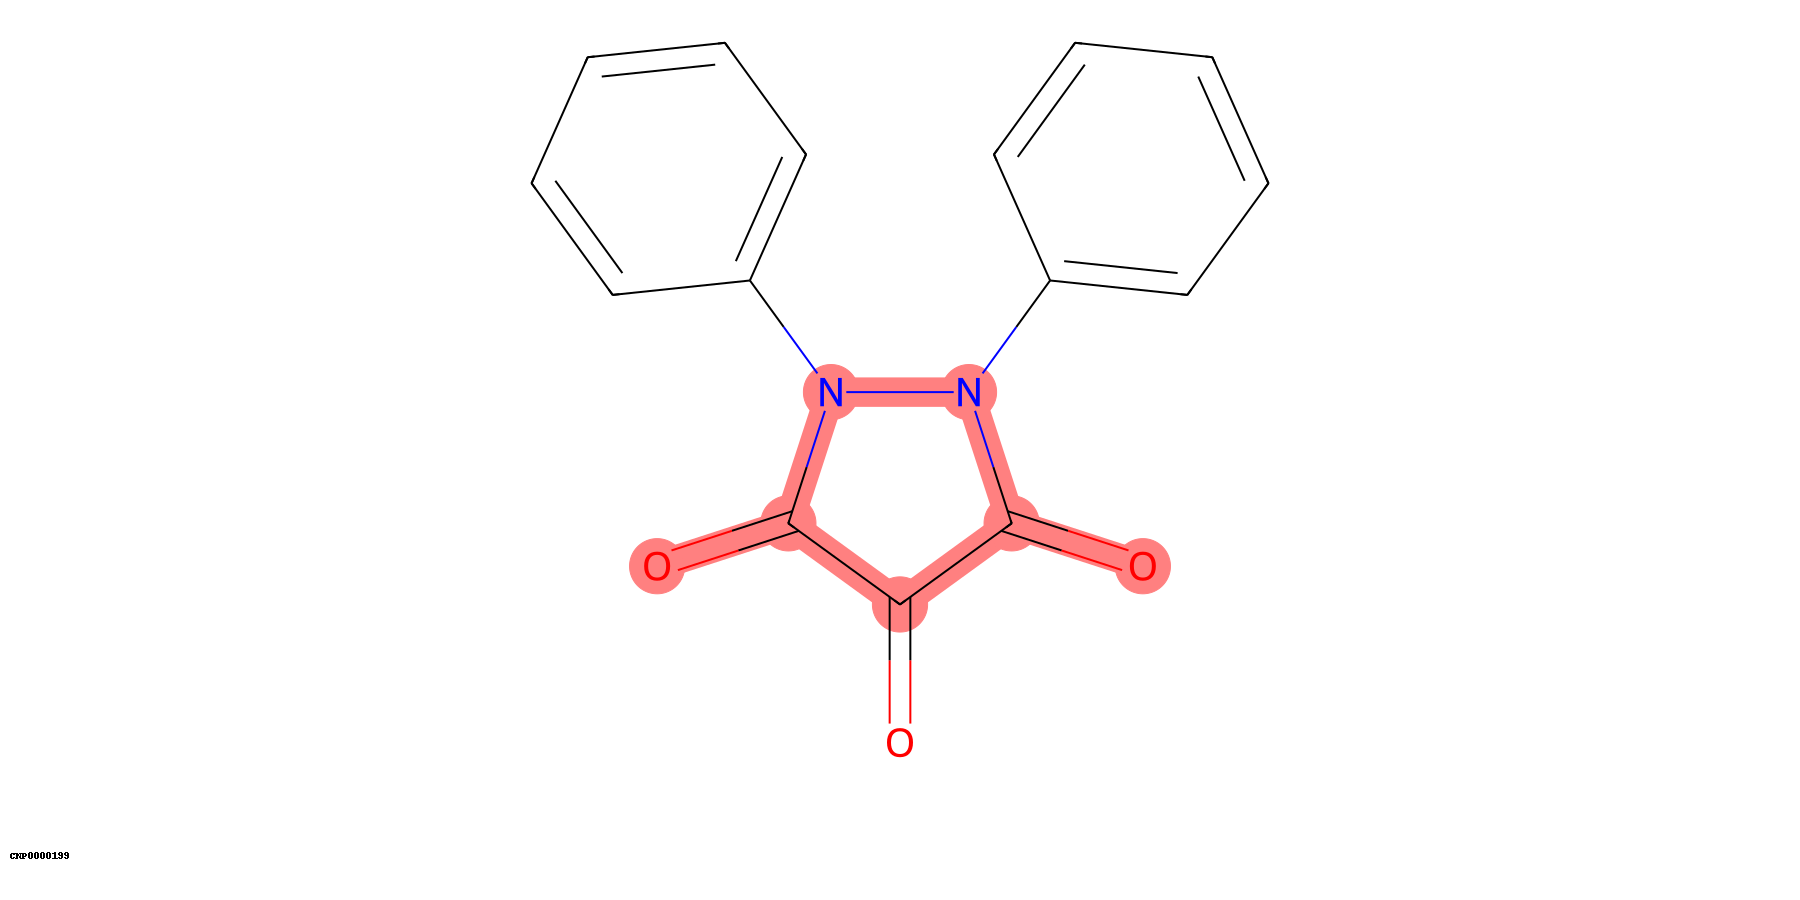

In [76]:
import os
from rdkit.Chem import Draw
from rdkit.Chem import AllChem
from PIL import Image as PILImage, ImageDraw, ImageFont
from IPython.display import display, Image

# Function to annotate images with molecule names and highlight the substructure, then save the images
def draw_molecules_with_annotations(mols, names, substructure, size=(400, 400), dpi=300):
    annotated_image_paths = []
    for i, mol in enumerate(mols):
        # Generate 2D coordinates for the molecule
        AllChem.Compute2DCoords(mol)
        # Get the indices of the atoms in the substructure
        match = mol.GetSubstructMatch(substructure)
        #bondsToHighlight = mol.GetSubstructMatch(substructure)
        bondsToHighlight = [bond.GetIdx() 
                            for bond in mol.GetBonds() 
                            if mol.GetAtomWithIdx(bond.GetBeginAtomIdx()).GetIdx() in match 
                            and mol.GetAtomWithIdx(bond.GetEndAtomIdx()).GetIdx() in match]
        
        # Draw molecule with substructure highlighted in higher resolution
        mol_image = Draw.MolToImage(mol, highlightAtoms=match, highlightBonds = bondsToHighlight, size=size)
        
        # Create an image with extra space to annotate in higher resolution
        annotated_image = PILImage.new('RGB', (mol_image.width, mol_image.height + 100), 'white')
        # Paste the molecule image on the annotated image
        annotated_image.paste(mol_image, (0, 0))
        # Draw the annotations
        draw = ImageDraw.Draw(annotated_image)
        font = ImageFont.load_default()
        # Add molecule name
        draw.text((10, mol_image.height + 50), f"{names[i]}", (0, 0, 0), font=font)
        # Save the image to a file with higher dpi
        image_filename = f"{names[i]}.png"
        image_path = os.path.join(os.getcwd(), image_filename)
        annotated_image.save(image_path, 'PNG', dpi=(dpi, dpi))
        annotated_image_paths.append(image_path)
    return annotated_image_paths

substructure = Chem.MolFromSmarts(substructure_smarts_pattern)
molecules_with_substructure = [mol for mol in molecules if mol.HasSubstructMatch(substructure)]
molecule_names = [mol.GetProp('_Name') if mol.HasProp('_Name') else "Unnamed" for mol in molecules_with_substructure]

# Adjust the number to how many molecules you'd like to display
num_to_display = 500
size = (1800, 800)  # Size of the image: width x height in pixels
dpi = 300  # Dots per inch for the image file

# Generate and save the annotated images
annotated_image_paths = draw_molecules_with_annotations(molecules_with_substructure[:num_to_display], molecule_names[:num_to_display], substructure, size=size, dpi=dpi)

# Display the annotated images in a grid
for image_path in annotated_image_paths:
    display(Image(filename=image_path))
